In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import torch
import transformers
from transformers import BertForTokenClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup

!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange
import torch.optim as optim
from seqeval.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

MAX_LEN = 75
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

transformers.__version__
torch.__version__

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=6a906d75429e2e63aeb9ad11daeae0f28154e5f7a4fc77a32166b97a33603b5d
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
Successfully built seqeval


In [2]:
train = pd.read_csv("/kaggle/input/voc-processed-data/train-nl.tsv", sep="\t")
len(train)

359695

In [3]:
train.head()

,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# language = nl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,# document_path = ../data/annotated_data/A/NL-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,heste,O,O,O,O,O,O,_
4,afschrift,O,O,O,O,O,O,_


It is worth noting that the data is imbalanced, with the "O" label being significantly more frequent than the named entity labels. This may impact the performance of a machine learning model trained on this data, as the model may have a bias towards predicting the "O" label due to its higher frequency in the data.

https://spraakbanken.gu.se/sites/default/files/2022/SLTC-2020_paper_4.pdf this paper trained ML models with both undersampling as oversampling techniques and got the highest score for oversampling. thus we will also use this tenchnique

In [6]:
df = train
df['DOC PATH'] = df['TOKEN'].str.extract(r'# document_path = (.*)', expand=False).ffill()

In [7]:
# Move Sentence # to the front
sentence_col = df.pop('DOC PATH')
df.insert(0, 'DOC PATH', sentence_col)

df = df.dropna()
print(df.isnull().sum())
# df = df.dropna(subset=["NE-MAIN"])
# df = df.dropna(subset=["TOKEN"])

df.head()

DOC PATH               0
TOKEN                  0
NE-MAIN                0
NE-PER-NAME            0
NE-PER-GENDER          0
NE-PER-LEGAL-STATUS    0
NE-PER-ROLE            0
NE-ORG-BENEFICIARY     0
MISC                   0
dtype: int64


,DOC PATH,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
3,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,heste,O,O,O,O,O,O,_
4,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,afschrift,O,O,O,O,O,O,_
5,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,m,O,O,O,O,O,O,_
6,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,In,O,O,O,O,O,O,_
7,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,den,O,O,O,O,O,O,_


In [8]:
counts = df['NE-MAIN'].value_counts()

# Create a dictionary mapping each class to its count
class_counts = {cls: count for cls, count in zip(counts.index, counts.values)}
class_counts

{'O': 321259,
 'I-Person': 15444,
 'B-Person': 8216,
 'I-Place': 3766,
 'B-Place': 2856,
 'I-Organization': 2155,
 'B-Organization': 741,
 'I-Organization,B-Place': 208,
 'I-Organization,I-Place': 111,
 'I-Person,B-Place': 105,
 'I-Person,I-Place': 54,
 'B-Organization,I-Place': 25,
 'B-Person,I-Place': 19,
 'I-Organization,I-Person': 4,
 'B-Organization,B-Place': 2,
 'B-Person,B-Place': 2,
 'B-Organization,I-Person': 1,
 'I-Organization,I-Person,B-Place': 1,
 'I-Organization,I-Person,I-Place': 1}

In [9]:
# Define the under-sampler and over-sampler
under_sampler = RandomUnderSampler(sampling_strategy={'O': 321259,
 'I-Person': 15444,
 'B-Person': 8216,
 'I-Place': 3766,
 'B-Place': 2856,
 'I-Organization': 2155,
 'B-Organization': 741,
 'I-Organization,B-Place': 208,
 'I-Organization,I-Place': 111,
 'I-Person,B-Place': 105,
 'I-Person,I-Place': 54,
 'B-Organization,I-Place': 25,
 'B-Person,I-Place': 19,
 'I-Organization,I-Person': 4,
 'B-Organization,B-Place': 2,
 'B-Person,B-Place': 2,
 'B-Organization,I-Person': 1,
 'I-Organization,I-Person,B-Place': 1,
 'I-Organization,I-Person,I-Place': 1})

over_sampler = RandomOverSampler(sampling_strategy="not majority") # Randomly over-sample minority class to have 50% of majority class

# Apply the over-sampler and under-sampler to the training data
X_train = df.drop(columns=['NE-MAIN'])
y_train = df['NE-MAIN']

# First, under-sample the majority class
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
# Then, over-sample the minority class on the under-sampled data
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train_under, y_train_under)

# Convert the resampled data back to a dataframe
df_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [16]:
df_resampled.columns

Index(['DOC PATH', 'TOKEN', 'NE-PER-NAME', 'NE-PER-GENDER',
       'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'NE-ORG-BENEFICIARY', 'MISC',
       'NE-MAIN'],
      dtype='object')

In [20]:
df_resampled['NE-MAIN'].value_counts()

B-Organization                     321259
I-Organization,I-Person            321259
I-Place                            321259
I-Person,I-Place                   321259
I-Person,B-Place                   321259
I-Person                           321259
I-Organization,I-Place             321259
I-Organization,I-Person,I-Place    321259
I-Organization,I-Person,B-Place    321259
I-Organization,B-Place             321259
B-Organization,B-Place             321259
I-Organization                     321259
B-Place                            321259
B-Person,I-Place                   321259
B-Person,B-Place                   321259
B-Person                           321259
B-Organization,I-Place             321259
B-Organization,I-Person            321259
O                                  321259
Name: NE-MAIN, dtype: int64

In [ ]:
# df[(df != 'O').all(axis=1)]

In [ ]:
# df[(df.iloc[:, :-3] != 'O').all(axis=1)]

In [21]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["TOKEN"].values.tolist(),
                                                     s["NE-MAIN"].values.tolist())]
        self.grouped = self.data.groupby("DOC PATH").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [22]:
getter = SentenceGetter(df_resampled)

In [23]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]

The sentences are annotated with the BIO-schema and the labels look like this.

In [24]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['B-Person', 'B-Person', 'B-Person', 'B-Person', 'B-Person', 'B-Person', 'B-Person', 'B-Person', 'B-Place', 'B-Place', 'B-Place', 'B-Place', 'B-Place', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'I-Place', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [25]:
tag_values = list(set(df_resampled["NE-MAIN"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [26]:
tag2idx

{'I-Organization,B-Place': 0,
 'B-Organization,I-Place': 1,
 'I-Person,I-Place': 2,
 'B-Organization': 3,
 'B-Person,I-Place': 4,
 'B-Organization,B-Place': 5,
 'O': 6,
 'I-Organization': 7,
 'B-Organization,I-Person': 8,
 'B-Place': 9,
 'I-Organization,I-Person': 10,
 'I-Organization,I-Person,I-Place': 11,
 'B-Person,B-Place': 12,
 'I-Place': 13,
 'B-Person': 14,
 'I-Organization,I-Person,B-Place': 15,
 'I-Organization,I-Place': 16,
 'I-Person,B-Place': 17,
 'I-Person': 18,
 'PAD': 19}

In [ ]:
def get_tag_distribution(df, tag_col):
    tag_distribution = df.groupby(tag_col).size().reset_index(name='counts')
    tag_distribution = tag_distribution.sort_values('counts', ascending=False)
    tag_distribution['percentage'] = (tag_distribution['counts'] / tag_distribution['counts'].sum()) * 100
    return tag_distribution

columns = ['NE-MAIN', 'NE-PER-NAME', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'NE-ORG-BENEFICIARY', 'MISC']
for col in columns:
    print(f"Tag distribution for {col}:")
    print(get_tag_distribution(df, col))
    print()

In [27]:
classes = list(filter(lambda x: x not in ["O", np.nan], list(df_resampled["NE-MAIN"].unique())))
print(classes)

['B-Organization', 'B-Organization,B-Place', 'B-Organization,I-Person', 'B-Organization,I-Place', 'B-Person', 'B-Person,B-Place', 'B-Person,I-Place', 'B-Place', 'I-Organization', 'I-Organization,B-Place', 'I-Organization,I-Person', 'I-Organization,I-Person,B-Place', 'I-Organization,I-Person,I-Place', 'I-Organization,I-Place', 'I-Person', 'I-Person,B-Place', 'I-Person,I-Place', 'I-Place']


In [28]:
tokenizer = BertTokenizer.from_pretrained('GroNLP/bert-base-dutch-cased', do_lower_case=False) #bert-base-cased

In [29]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [30]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [31]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [32]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [33]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [34]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [35]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [36]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [37]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [38]:
model = BertForTokenClassification.from_pretrained(
    "GroNLP/bert-base-dutch-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased

In [39]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = optim.AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [40]:
epochs = 7
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [41]:
valid_seq_lens = []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    seq_lens = b_input_mask.sum(dim=1).tolist()
    valid_seq_lens.extend(seq_lens)

In [42]:
def nested_list(lst, seq_lens):
    nested = []
    i = 0
    for seq_len in seq_lens:
        nested.append(lst[i:i+seq_len])
        i += seq_len
    return nested

In [43]:
valid_seq_lens = [int(x) for x in valid_seq_lens]

In [44]:
loss_values, validation_loss_values = [], []
# precision_values = []
# recall_values = []

for _ in trange(epochs, desc="Epoch"):
    model.train()
    total_loss = 0
    total_precision = 0
    total_recall = 0
    total_samples = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        
#         logits = outputs[1]
#         preds = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
        
        # calculate precision and recall
#         preds_flat = np.argmax(preds, axis=2).flatten()
#         labels_flat = label_ids.flatten()
#         precision = precision_score(labels_flat, preds_flat, average='weighted', zero_division=0)
#         recall = recall_score(labels_flat, preds_flat, average='weighted', zero_division=0)
#         total_precision += precision * len(labels_flat)
#         total_recall += recall * len(labels_flat)
#         total_samples += len(labels_flat)
        
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    loss_values.append(avg_train_loss)
    
#     avg_train_precision = total_precision / total_samples
#     print("Average train precision: {}".format(avg_train_precision))
#     precision_values.append(avg_train_precision)
    
#     avg_train_recall = total_recall / total_samples
#     print("Average train recall: {}".format(avg_train_recall))
#     recall_values.append(avg_train_recall)
    
#     == EVAL ==
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    for p, l in zip(predictions, true_labels):
        for p_i, l_i in zip(p, l):
            if tag_values[l_i] != "PAD" and l_i >= len(tag_values):
                print("Problematic index:", l_i)
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    
    pred_tags_nested = nested_list(pred_tags,valid_seq_lens)
    valid_tags_nested = nested_list(valid_tags,valid_seq_lens)
#     print("Validation F1-Score: {}".format(f1_score(pred_tags_nested, valid_tags_nested)))
    
    report = classification_report(valid_tags_nested, pred_tags_nested, digits=4)
    print(report)
    
    print()

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Average train loss: 1.125093807776769
Validation loss: 0.6084116697311401
Validation Accuracy: 0.810042194092827


Epoch:  14%|█▍        | 1/7 [08:04<48:28, 484.75s/it]

                      precision    recall  f1-score   support

        Organization     0.0189    0.0053    0.0083       188
Organization,B-Place     0.0000    0.0000    0.0000        24
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.6531    0.8324    0.7319      2088
      Person,B-Place     0.0000    0.0000    0.0000         5
      Person,I-Place     0.0000    0.0000    0.0000        14
               Place     0.5203    0.2668    0.3527       671

           micro avg     0.6272    0.6372    0.6322      3010
           macro avg     0.1703    0.1578    0.1561      3010
        weighted avg     0.5703    0.6372    0.5869      3010


Average train loss: 0.45967734389834936
Validation loss: 0.37424508929252626
Validation Accuracy: 0.8843881856540085


Epoch:  29%|██▊       | 2/7 [16:03<40:07, 481.42s/it]

                      precision    recall  f1-score   support

        Organization     0.5021    0.6330    0.5600       188
Organization,B-Place     0.0000    0.0000    0.0000        24
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.8195    0.8065    0.8129      2088
      Person,B-Place     0.0000    0.0000    0.0000         5
      Person,I-Place     0.0000    0.0000    0.0000        14
               Place     0.6600    0.5380    0.5928       671

           micro avg     0.7622    0.7189    0.7400      3010
           macro avg     0.2831    0.2825    0.2808      3010
        weighted avg     0.7469    0.7189    0.7310      3010


Average train loss: 0.28428246246443856
Validation loss: 0.327020126581192
Validation Accuracy: 0.8931645569620253


Epoch:  43%|████▎     | 3/7 [24:03<32:02, 480.52s/it]

                      precision    recall  f1-score   support

        Organization     0.5000    0.6915    0.5804       188
Organization,B-Place     0.0000    0.0000    0.0000        24
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.8520    0.8161    0.8337      2088
      Person,B-Place     0.0000    0.0000    0.0000         5
      Person,I-Place     0.0000    0.0000    0.0000        14
               Place     0.5922    0.7422    0.6587       671

           micro avg     0.7520    0.7748    0.7632      3010
           macro avg     0.2777    0.3214    0.2961      3010
        weighted avg     0.7543    0.7748    0.7614      3010


Average train loss: 0.20545777810944452
Validation loss: 0.2898130863904953
Validation Accuracy: 0.9090295358649789


Epoch:  57%|█████▋    | 4/7 [32:04<24:02, 480.98s/it]

                      precision    recall  f1-score   support

        Organization     0.5628    0.6915    0.6205       188
Organization,B-Place     0.1429    0.0833    0.1053        24
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.8714    0.8338    0.8522      2088
      Person,B-Place     0.0000    0.0000    0.0000         5
      Person,I-Place     0.0000    0.0000    0.0000        14
               Place     0.7172    0.6841    0.7002       671

           micro avg     0.8089    0.7748    0.7914      3010
           macro avg     0.3277    0.3275    0.3255      3010
        weighted avg     0.8006    0.7748    0.7868      3010


Average train loss: 0.16079130868117014
Validation loss: 0.29633170664310454
Validation Accuracy: 0.9085232067510548


Epoch:  71%|███████▏  | 5/7 [40:09<16:04, 482.33s/it]

                      precision    recall  f1-score   support

        Organization     0.6140    0.7447    0.6731       188
Organization,B-Place     0.0909    0.0833    0.0870        24
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.8504    0.8659    0.8581      2088
      Person,B-Place     0.0000    0.0000    0.0000         5
      Person,I-Place     0.0000    0.0000    0.0000        14
               Place     0.6990    0.7303    0.7143       671

           micro avg     0.7930    0.8106    0.8017      3010
           macro avg     0.3221    0.3463    0.3332      3010
        weighted avg     0.7848    0.8106    0.7972      3010


Average train loss: 0.1293493252661493
Validation loss: 0.27944648265838623
Validation Accuracy: 0.9153586497890296


Epoch:  86%|████████▌ | 6/7 [48:13<08:02, 482.80s/it]

                      precision    recall  f1-score   support

        Organization     0.6897    0.7447    0.7161       188
Organization,B-Place     0.1176    0.0833    0.0976        24
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.8620    0.8673    0.8646      2088
      Person,B-Place     0.0000    0.0000    0.0000         5
      Person,I-Place     0.0000    0.0000    0.0000        14
               Place     0.6742    0.7526    0.7113       671

           micro avg     0.8007    0.8166    0.8086      3010
           macro avg     0.3348    0.3497    0.3414      3010
        weighted avg     0.7923    0.8166    0.8039      3010


Average train loss: 0.11618741932842466
Validation loss: 0.2835340589284897
Validation Accuracy: 0.9135864978902953


Epoch: 100%|██████████| 7/7 [56:16<00:00, 482.30s/it]

                      precision    recall  f1-score   support

        Organization     0.6530    0.7606    0.7027       188
Organization,B-Place     0.1176    0.0833    0.0976        24
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.8679    0.8587    0.8633      2088
      Person,B-Place     0.0000    0.0000    0.0000         5
      Person,I-Place     0.0000    0.0000    0.0000        14
               Place     0.6701    0.7750    0.7187       671

           micro avg     0.7986    0.8166    0.8075      3010
           macro avg     0.3298    0.3540    0.3403      3010
        weighted avg     0.7931    0.8166    0.8037      3010




Really high accuracy but very low f1 score = This could indicate underfitting on an unbalanced dataset.

Take a case of binary classification for example. You have 100 testing examples. 82 of them are from class A and the other 18 are from class B. Your model can achieve 82% accuracy simply by classifying A each time! Such is why the F1 score is so important in evaluating models on unbalanced datasets; it accounts for the performance of all classes.

There are two things you may research to improve your model.

Modify your model
Balance your dataset to improve data quality

https://arxiv.org/pdf/1601.04756.pdf --> Between the two techniques (RO and RU), the results also showed that RO is preferable. The reason of this is obvious, since RU removes instances of the majority class, as the classifier is generated, it missed important concepts about the majority class resulting to a better performance on some minority classes but jeopardized performance on the major- ity class.

<AxesSubplot:>

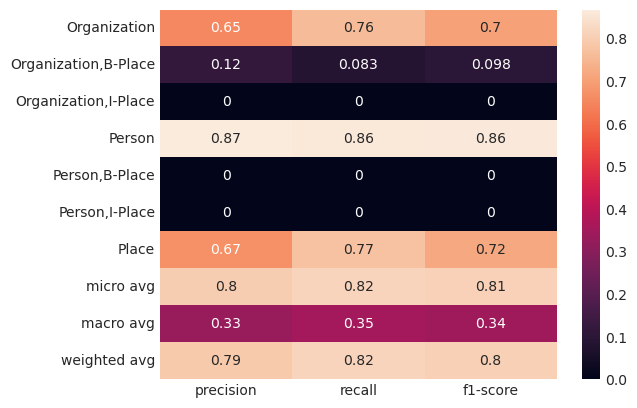

In [45]:
report_ = classification_report(valid_tags_nested, pred_tags_nested, digits=4,output_dict=True)
sns.heatmap(pd.DataFrame(report_).iloc[:-1, :].T, annot=True)

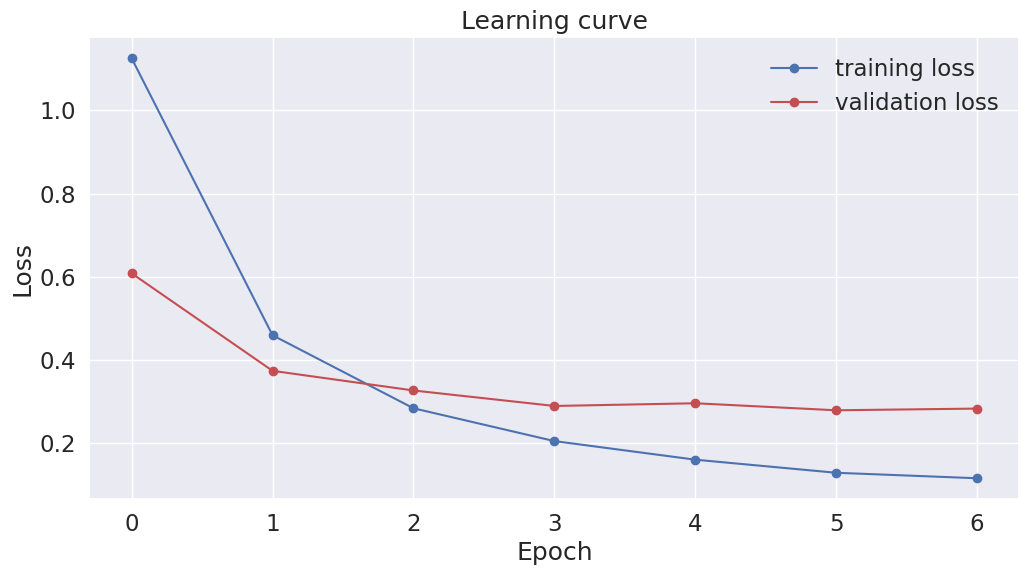

In [46]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Apply the model to a new sentence


In [47]:
# https://zoekintranscripties.nl/document/NL-HaNA/1.04.02/7780/0017?index=9
test_sentence = """
twee agter den anderen gesk: verklaringen van den bootsman
en gew: opsiender der Equipagie goederen tot Japara Jan
fransz: van amsterdam, wegens de aenhalingh van 3.
picols amphioen tot damack door den fiscael willem
drost en het overbrengen denselve tot Japara, mitsgaders het
bergen ofte opslaen van de bewuste 86. Canassers aenge„
haelden amphioen van den Engelsman griffit inde
woninge van den gew: gesaghebber goodschalk
beandwoorde interrogaterium door gem: bootsman Jan
france, over de voorsz. 86. Canassers amphioen —
verklaringe vanden Engelsman david slair adsistent
op het Engels- scheepje siaian marchant, nopende de
aenhaelinge van bovengenoemden amphioen en 19: pees.
armosijnen, en desselfs aengewende debvooren tot het weder.
verkrijgen van’t deselve
biedigde verclaringe door Jan boerssen schipper en pieter beijerus
boekhouder op het Iagtje de schaephender, wegens de aensprake
van den Engelsman david blair tot Japara aenden
fiscael willem drost thaerder presentie om de sijner aen
gehaelde 19. armosijnen en zijn bekomen antwoord van
gene, drost dat deselve den gesaghebber goodschalk waren.
overgegeven &amp;:a
"""

In [53]:
test_sentence = """
"Ich hoop dat dit scrift u wael bericht. Ich ben Wilhelm van den Ertem, een cöpman ende scheepsheere in dienst van de Oost-Indische Compagnie 
der Nederlanden. Ich scryve u om u te informeren van den welgelukten vollendinge van mien laetste reyse, dewelcke de transportatie van speceryen 
en gheenslaefde volcke, onder andere Mary Jane ende Betty Hopes, van Oost-Indien naer Europa omvatte.

Ghy zout mogelijck bekend zijn dat de VOC in groten handel gewikkelts is met Oost-Indien, alwaer wy vele waerdecommoditeiten zoals speceryen, 
textielen ende edelmetalen verkrygen. Maer om onse dominantie in dese handel te behouden, is den transport van dese goederen naer Europa, 
dikwijls via lange ende gevaerlicke zeereysen, nodich.

Tijdens mien leste tocht was mien scheep beladen met diverse speceryen zoals nootmuscaet, kruidnagel ende kaneel, die ich met winstgevendheid 
in Amsterdam verhandelen wil. Tevens heb ich een aantal gheenslaefde volcke uit Oost-Indien meegenomen, die als arbeiders verkocht sullen worden 
om op suiker- ende koffieplantages in Amerika te werken.

Ich weet dat het slavernij-praktijk controversieel is en ethische vragen oproept. Nochtans verzekere ich u dat ich mien menselijk lading met 
de uutmostende respect ende zorgvuldigheid tijdens de reyse heb behandeld. Daerbij is het van belang om op te merken dat de VOC, als compagnie, 
werkt binne het juridische kader van de Nederlandse regering en haar regelgeving naerkomt
"""

In [54]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence])

In [55]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [56]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [57]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	"
B-Person	Ich
B-Person	hoop
O	dat
O	dit
O	scrift
O	u
O	wael
O	bericht
O	.
I-Person	Ich
I-Person	ben
I-Person	Wilhelm
I-Person	van
I-Person	den
I-Person	Ertem
I-Person	,
I-Person	een
I-Person	cöpman
I-Person	ende
I-Person	scheepsheere
I-Person	in
I-Person	dienst
I-Person	van
I-Person	de
I-Place	Oost
I-Person	-
I-Person	Indische
I-Place	Compagnie
I-Organization	der
I-Place	Nederlanden
O	.
O	Ich
O	scryve
O	u
O	om
O	u
O	te
O	informeren
O	van
O	den
O	welgelukten
O	vollendinge
O	van
O	mien
O	laetste
O	reyse
O	,
O	dewelcke
O	de
O	transportatie
O	van
O	speceryen
O	en
O	gheenslaefde
O	volcke
O	,
O	onder
O	andere
I-Person	Mary
I-Person	Jane
I-Person	ende
I-Person	Betty
I-Person	Hopes
I-Person	,
I-Person	van
O	Oost
O	-
O	Indien
O	naer
O	Europa
O	omvatte
O	.
O	Ghy
O	zout
O	mogelijck
O	bekend
O	zijn
O	dat
O	de
O	VOC
O	in
O	groten
O	handel
O	gewikkelts
O	is
O	met
O	Oost
O	-
O	Indien
O	,
O	alwaer
O	wy
O	vele
O	waerdecommoditeiten
O	zoals
O	speceryen
O	,
O	textielen
O	ende
O	edelmetalen
O	v